# DNN Visuomotor Control 
Use standard control to move the needle to the targets. <br> 
predict the needle and gate position from the image or use the ground truth

## Imports
* pytorch_datasets for Dataset class, DataLoader
* numpy for math 
* torch for deep learning library
* torchvision for deep learning vision library 
* multiprocessing to run on multiple cpus (if applicable)
* random to select random trials/frames in _get__item_, and to make random datasplits
* matplotlib for displaying image frames
* pdb (debugging)
* controller: the PIDcontroller class (we implemented this)

In [9]:
import sys
sys.path.insert(0, '/home/molly/workspace/Utils/pytorch_datasets/')
sys.path.insert(0, '/home/molly/workspace/Surgical_Automation/src/needle_master_tools/scripts/')

import random 
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib import patches
from pdb import set_trace as woah
from controller import PIDcontroller
from context import needlemaster as nm
from models import *

import torch
import torchvision
import pytorch_datasets
import torch.nn.functional as F

Code to set up the environment. Choose if the deep learning will run on the CPU or GPU. Initialize the torch random seed, and if using a GPU the GPU random seed. 

In [2]:
torch.manual_seed(random.randint(1, 10000))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if(DEVICE == "cuda:0"):
    torch.cuda.manual_seed(random.randint(1, 10000))
    # Disable nondeterministic ops (not sure if critical but better safe than sorry)
    torch.backends.cudnn.enabled = False  

## Introduction
This notebook uses the Pytorch Datasets wrapper to write a data loader for the NeedleMaster dataset. 

* __NeedleMaster__ is an Android game developped by Chris Paxton (https://github.com/cpaxton/needle_master_tools.) Images from recorded demonstrations were rendered to create a toy dataset with images, needle poses, and user actions. This dataset is currently on a local directory. For information contact molly@jhu.edu. 

## Loading Data 

In [3]:
ENVIRONMENT = None # 
nf = pytorch_datasets.NeedleFrames('/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/', \
                                  environment=ENVIRONMENT)

## Experiment parameters

In [6]:
action_constraints = [10, np.pi/10]           # constraints on allowable motion
parameters         = [0.1,0.0009]             # proportional control parameters --- these have been hand tuned
pid                = PIDcontroller(params=parameters, bounds=action_constraints)

save_images        = False
path               = '/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/'
env_path           = path + 'environments/environment_14.txt'
save_path          = path + 'trajectories/control/test_demo/'
environment        = nm.Environment(env_path, save_path=save_path)

## Load trained model 
Model trained on all levels except level 14 (Mountain). 

In [10]:
model_type = 'resnet18'
model_mode = 'classify'
model_path = path + 'cnn_vision_block/trained_models/'
model = torch.load(model_path + model_type + '_' + model_mode)

In [12]:
frame = environment.render(save_image=save_images, save_path=save_path)

In [19]:
frame.shape

torch.Size([3, 1920, 1080])

In [ ]:
plt.imread('')

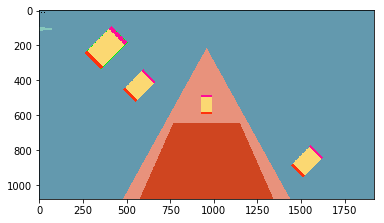

In [20]:
fig = plt.figure()
plt.imshow(frame.permute(2,1,0))
plt.show()

## Run Contol 
Use ground truth gate information with needle position predicted by CNN

In [ ]:
done  = False
frame = environment.render(save_image=save_images)

while(not done):
    if(environment.next_gate is not None):
        next_gate = environment.gates[environment.next_gate]
        needle_inference = model()
    else:
        next_gate = None
        needle_inference = model()
        
    action  = pid.step(needle_inference, next_gate)
    _, _, done   = environment.step(action, 'play')

In [ ]:
print("________________________")
environment.score(True)
print("________________________")

### Evaluate performance